In [1]:
import sys
sys.path.append('../')
#
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from time import time
#
from VQE import VQE
from utils import get_backend_conectivity, BeH2, LiH, H2, H2O
# Importing standard Qiskit libraries
from qiskit import IBMQ, QuantumCircuit
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.algorithms.optimizers import SPSA

In [2]:
# molecule = H2 
# distances = np.linspace(0.2,4,16)

# molecule = LiH 
# distances = np.linspace(0.5,5,16)

molecule = BeH2
distances = np.linspace(0.5,5,16)

# molecule = H2O
# distances = np.linspace(0.7,1.3,16)

In [3]:
opt, init_state = molecule(operator=True, initial_state=True)
num_qubits = opt.num_qubits
num_qubits

6

In [9]:
print(opt)

(-1.057413529679954+2.7755575615628914e-17j) * II
+ (-0.3821759325213922-1.3877787807814457e-17j) * ZI
+ 0.38217593252139215 * IZ
- 0.011099508424042961 * ZZ
+ (0.18239260980002306+3.469446951953614e-18j) * XX


In [4]:
converter, problem = molecule(operator=False)
calc = GroundStateEigensolver( converter, NumPyMinimumEigensolver() )
res = calc.solve(problem)
res.total_energies

array([-7.88146143+0.j])

In [5]:
def GroundStateEigensolver_exact_loop( d ):
    converter, problem = molecule( d, operator=False )
    calc = GroundStateEigensolver( converter, NumPyMinimumEigensolver() )
    res = calc.solve(problem)
    return res.total_energies 

In [6]:
energies = Parallel(n_jobs=-1)( delayed(GroundStateEigensolver_exact_loop)(d) for d in distances )

C:\Users\lucia\miniconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


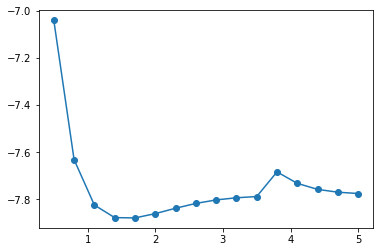

In [7]:
plt.plot( distances, energies, '-o' )

In [8]:
IBMQ.load_account()
provider      = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend_paris = provider.get_backend('ibmq_montreal')
WC_paris      = get_backend_conectivity(backend_paris)
backend_sim   = AerSimulator(method="statevector") # Backend for simulation
backend_noise = AerSimulator.from_backend(backend_paris) # Backend with noise model
NUM_SHOTS = 2**13  # Number of shots for each circuit

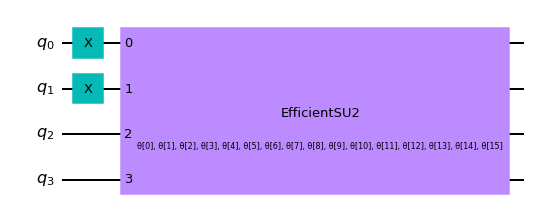

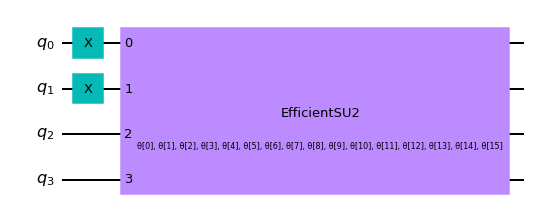

In [9]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = init_state.compose( EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1 ) )
ansatz.draw(output='mpl')

In [10]:
def callback( evals, params, energy, extra  ):  
    display("{}, {}".format(evals,energy))
    clear_output(wait=True)
    parameters.append(params)
    evaluations.append(evals)

parameters  = []
evaluations = []
energies    = [] 

optimizer = SPSA( maxiter=100, last_avg=1 )
num_var = ansatz.num_parameters
pars = [0.01] * num_var
vqe_solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled' )

C:\Users\lucia\Nextcloud\Programas\Github\Hardware-efficient-variational-quantum-eigensolver-with-entangled-measurements\Codes\tests\..\VQE.py:90: DeprecationWarning: 
The VariationalAlgorithm is reduced to an interface. Thus, the
ansatz property is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
  self.ansatz = ansatz
C:\Users\lucia\Nextcloud\Programas\Github\Hardware-efficient-variational-quantum-eigensolver-with-entangled-measurements\Codes\tests\..\VQE.py:99: DeprecationWarning: The VariationalAlgorithm class has been reduced to an abstract interface. Passing any arguments to the initializer is deprecated as of Qiskit Terra 0.18.0 and will be unsupported no sooner than 3 months after the release date.
  super().__init__(ansatz=ansatz,
C:\Users\lucia\miniconda3\lib\site-packages\qiskit\algorithms\variational_algorithm.py:88: DeprecationWarning: 
The VariationalAlgorithm is reduced to an interface. Thus, the
quantum_instance pro

In [11]:
converter, problem = molecule(operator=False)
calc = GroundStateEigensolver( converter, vqe_solver )
res = calc.solve(problem)
res.total_energies

C:\Users\lucia\Nextcloud\Programas\Github\Hardware-efficient-variational-quantum-eigensolver-with-entangled-measurements\Codes\tests\..\VQE.py:158: DeprecationWarning: 
The VariationalAlgorithm is reduced to an interface. Thus, the
ansatz property is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
  if operator is not None and self.ansatz is not None:
C:\Users\lucia\Nextcloud\Programas\Github\Hardware-efficient-variational-quantum-eigensolver-with-entangled-measurements\Codes\tests\..\VQE.py:352: DeprecationWarning: 
The VariationalAlgorithm is reduced to an interface. The
initial_point property will be made abstract no sooner than
3 months after the release date of Qiskit Terra 0.18.0. You should
make a concrete implementation in any derived class and not rely on
the implementation here which will be removed.
  vqresult = self.find_minimum(initial_point=self.initial_point,
C:\Users\lucia\Nextcloud\Programas\Github\Hardware-effici

array([-7.88063439+0.j])

In [12]:
def GroundStateEigensolver_vqe_loop( d ):
    converter, problem = molecule( d, operator=False )
    calc = GroundStateEigensolver( converter, vqe_solver )
    res = calc.solve(problem)
    return res.total_energies 

In [13]:
energies = Parallel(n_jobs=-1)( delayed(GroundStateEigensolver_vqe_loop)(d) for d in distances )

C:\Users\lucia\miniconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


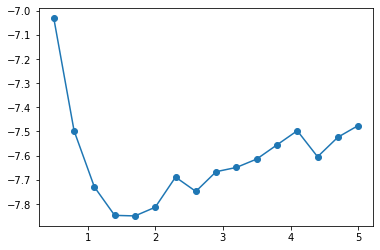

In [14]:
plt.plot( distances, energies, '-o' )